In [228]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
#from pandas.plotting import lag_plot
#from pandas import datetime

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller #ADF test -- Stationarity
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")


# Get data

In [315]:
df = pd.read_csv("../data/HistoricalQuotes.csv")
df.head(2)

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96


In [316]:
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df.head(2)

,Date,Close/Last,Volume,Open,High,Low
0,03/01/2010,$29.8557,137312041,$29.3928,$29.9286,$29.35
1,03/02/2010,$29.8357,141486282,$29.99,$30.1186,$29.6771


In [317]:
df.shape

(2518, 6)

In [318]:
df.dtypes

Date           object
 Close/Last    object
 Volume         int64
 Open          object
 High          object
 Low           object
dtype: object

In [319]:
df.columns

Index(['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low'], dtype='object')

In [320]:
df.columns = [ col.lstrip() for col in df.columns]
df.columns

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [321]:
df.head(2)

,Date,Close/Last,Volume,Open,High,Low
0,03/01/2010,$29.8557,137312041,$29.3928,$29.9286,$29.35
1,03/02/2010,$29.8357,141486282,$29.99,$30.1186,$29.6771


# Data processing

In [322]:
for col in ['Close/Last', 'Open', 'High', 'Low']:
    df[col] = df[col].apply(lambda x:x.replace('$', '')).astype('float64')

In [323]:
df.head(2)

,Date,Close/Last,Volume,Open,High,Low
0,03/01/2010,29.8557,137312041,29.3928,29.9286,29.3500
1,03/02/2010,29.8357,141486282,29.9900,30.1186,29.6771


In [324]:
df.dtypes

Date           object
Close/Last    float64
Volume          int64
Open          float64
High          float64
Low           float64
dtype: object

In [325]:
# convert the 'Date' column to datetime format
df['Date']= pd.to_datetime(df['Date'])
 
# Check the format of 'Date' column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2518 non-null   datetime64[ns]
 1   Close/Last  2518 non-null   float64       
 2   Volume      2518 non-null   int64         
 3   Open        2518 non-null   float64       
 4   High        2518 non-null   float64       
 5   Low         2518 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.2 KB


# Visualization

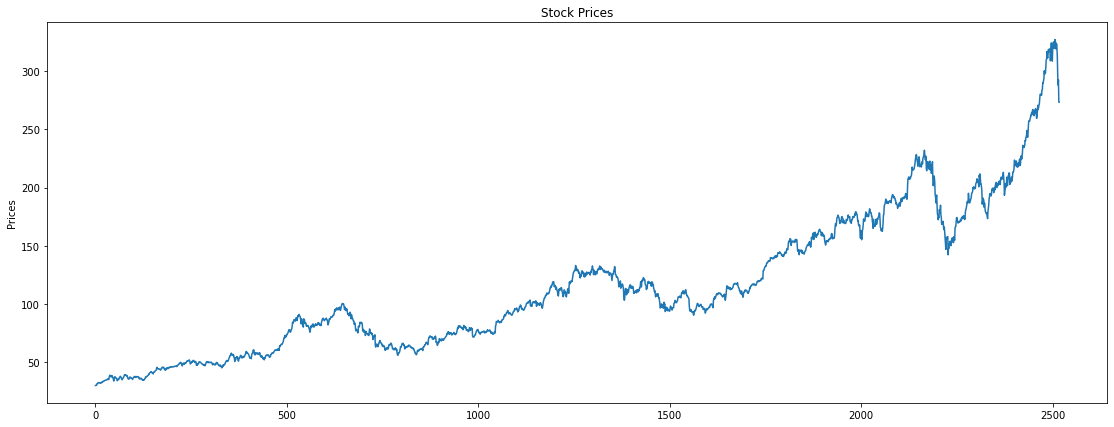

In [326]:
plt.figure(figsize=(19,7))
plt.title('Stock Prices')
plt.plot(df['Close/Last'])
plt.ylabel('Prices')
plt.show()

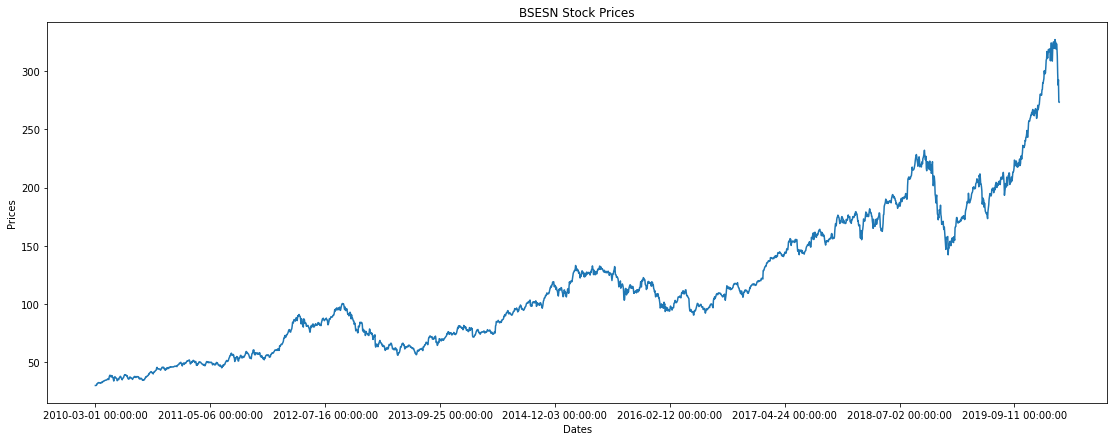

In [327]:
plt.figure(figsize=(19,7))
plt.title('BSESN Stock Prices')
plt.plot(df['Close/Last'])
plt.xticks(np.arange(0,2500, 300), df['Date'][0:2500:300])
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

# train and test split

In [328]:
##splitting dataset into train and test split
training_size=int(len(df)*0.7)
test_size=len(df)-training_size

train_data=df.loc[0:training_size,:]
test_data = df.loc[training_size:len(df),:]

train_data.shape, test_data.shape

((1763, 6), (756, 6))

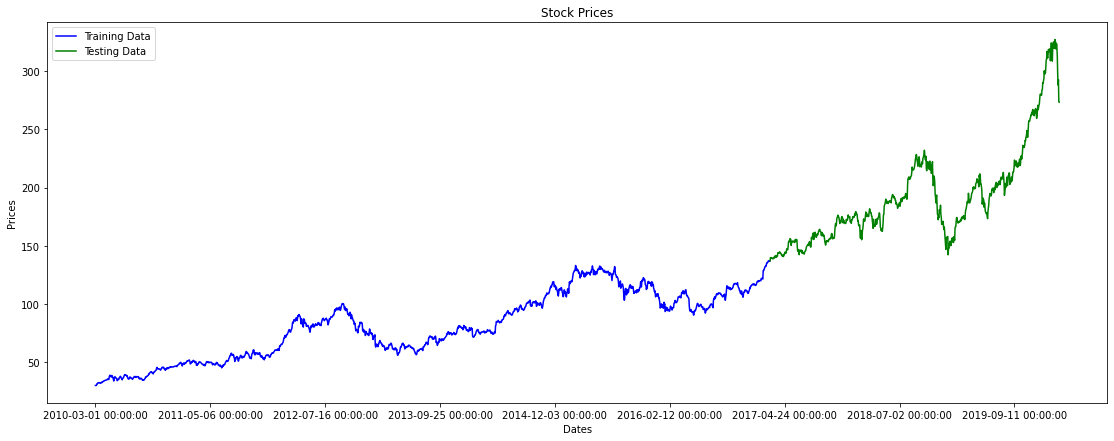

In [329]:
plt.figure(figsize=(19,7))
plt.title('Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Close/Last'], 'blue', label='Training Data')
plt.plot(test_data['Close/Last'], 'green', label='Testing Data')
plt.xticks(np.arange(0,2500, 300), df['Date'][0:2500:300])
plt.legend();

# Extracting Dataset : Close/Last , Date

In [330]:
dataset=df.copy()
dataset.set_index('Date', inplace=True)
dataset = dataset[['Close/Last']] 
dataset.head(2)

,Close/Last
Date,
2010-03-01,29.8557
2010-03-02,29.8357


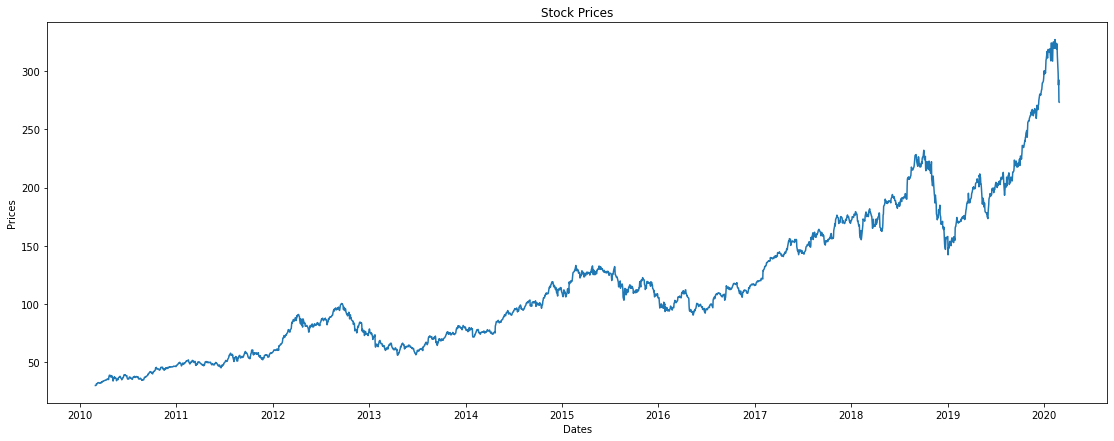

In [331]:
plt.figure(figsize=(19,7))
plt.title('Stock Prices')
plt.plot(dataset)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.show()

In [332]:
##splitting dataset into train and test split
training_size=int(len(dataset)*0.7)
test_size=len(dataset)-training_size

df_train=dataset[0:training_size]
df_test = dataset[training_size:len(df)]

df_train.shape, df_test.shape

((1762, 1), (756, 1))

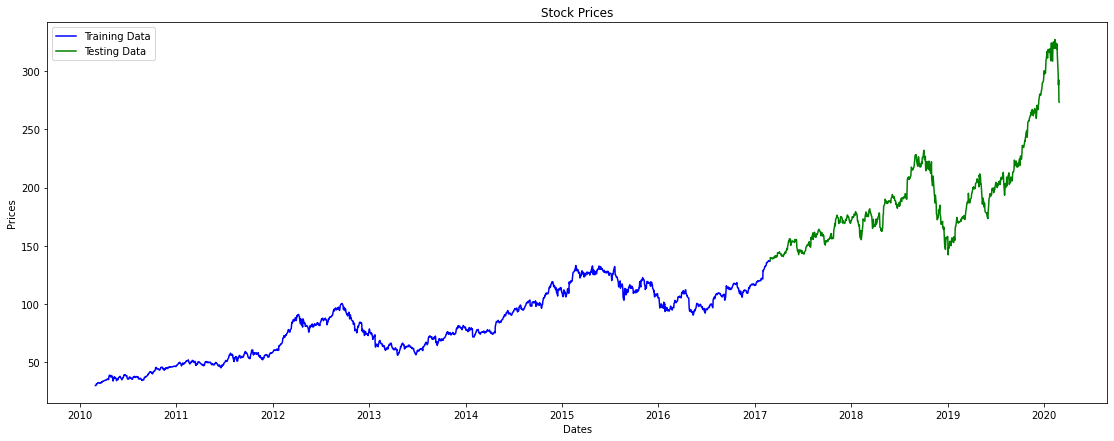

In [333]:
plt.figure(figsize=(19,7))
plt.title('Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_train, 'blue', label='Training Data')
plt.plot(df_test, 'green', label='Testing Data')
plt.legend();

# Moving average & Standard Deviation (STD)

## 7-day Moving average & STD

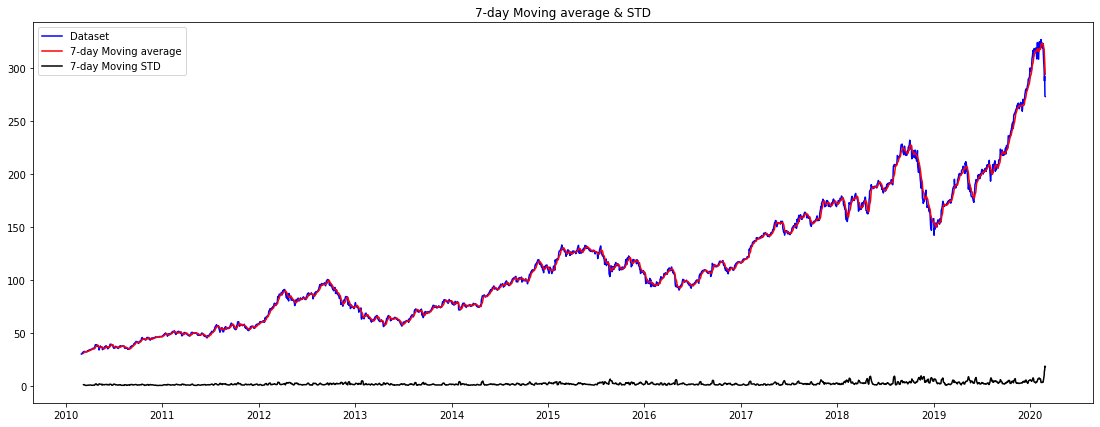

In [334]:
plt.figure(figsize=(19,7))

#Rolling window mean over a window size of 7 "here, 7 days"
rolling_mean = dataset['Close/Last'].rolling(window = 7).mean()
rolling_std = dataset['Close/Last'].rolling(window = 7).std()

plt.plot(dataset, color = 'blue', label = 'Dataset')
plt.plot(rolling_mean, color = 'red', label = '7-day Moving average')

plt.plot(rolling_std, color = 'black', label = '7-day Moving STD')
plt.legend(loc = 'best')
plt.title('7-day Moving average & STD')
plt.show()

## 1-year Moving average & STD

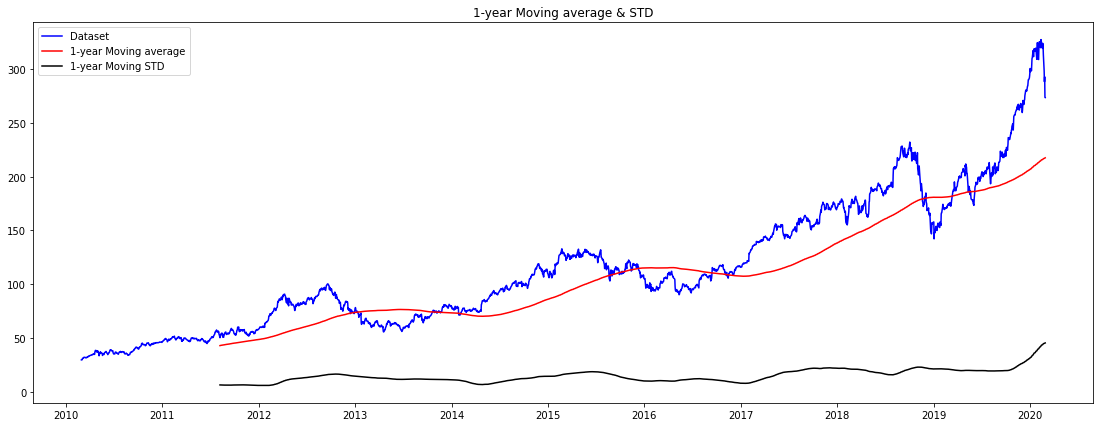

In [335]:
plt.figure(figsize=(19,7))

#Rolling window mean over a window size of 365 "here, 1 year"
rolling_mean = dataset['Close/Last'].rolling(window = 365).mean()
rolling_std = dataset['Close/Last'].rolling(window = 365).std()

plt.plot(dataset, color = 'blue', label = 'Dataset')
plt.plot(rolling_mean, color = 'red', label = '1-year Moving average')

plt.plot(rolling_std, color = 'black', label = '1-year Moving STD')
plt.legend(loc = 'best')
plt.title('1-year Moving average & STD')
plt.show()

## 1-month Moving average & STD

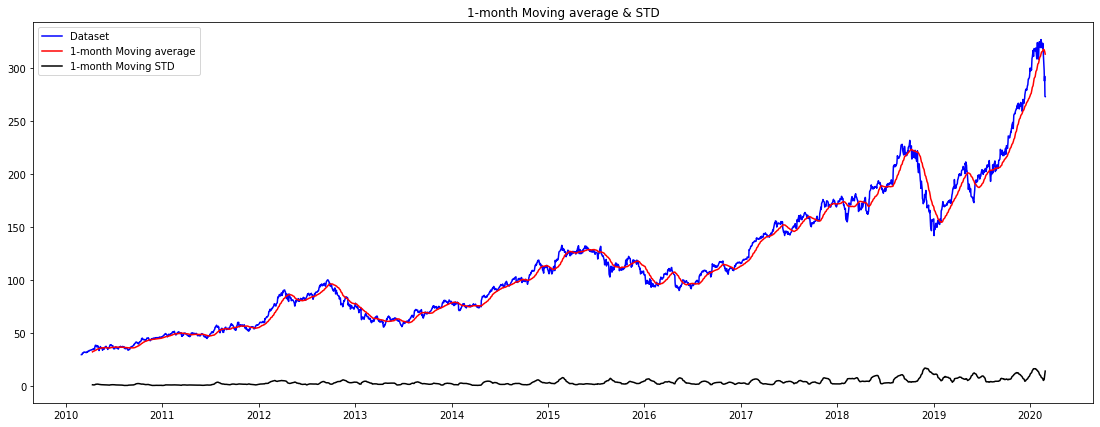

In [336]:
plt.figure(figsize=(19,7))

#Rolling window mean over a window size of 30 "here, 1 year"
rolling_mean = dataset['Close/Last'].rolling(window = 30).mean()
rolling_std = dataset['Close/Last'].rolling(window = 30).std()

plt.plot(dataset, color = 'blue', label = 'Dataset')
plt.plot(rolling_mean, color = 'red', label = '1-month Moving average')

plt.plot(rolling_std, color = 'black', label = '1-month Moving STD')
plt.legend(loc = 'best')
plt.title('1-month Moving average & STD')
plt.show()

# ADF TEST

In [337]:
# Check if price series is stationary
result = adfuller(dataset)
 
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print('Critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.04918130127669574
p-value: 0.9624152269389332
Critical values :
	1%: -3.432960050084045
	5%: -2.8626931078801285
	10%: -2.567383843706519


* ADF Statistic is not close to critical values
* p-value > 0.05

therefore the time series is not stationary.

# PACF PLOT -- without differenciation

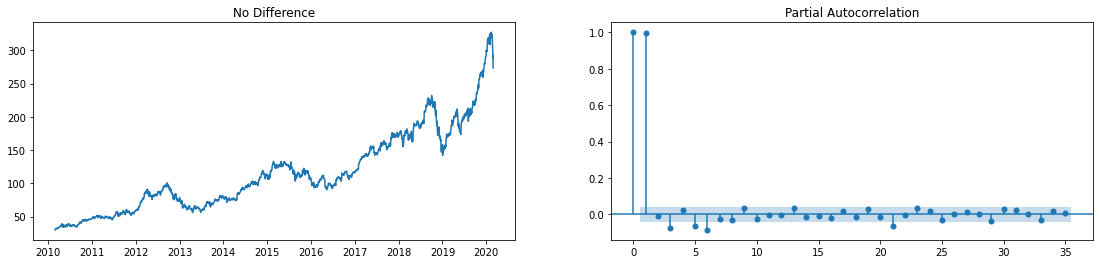

In [338]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 4))

ax1.plot(dataset)
ax1.set_title("No Difference")
#ax2.set_ylim(0, 1)
plot_pacf(dataset, ax=ax2);

# ACF PLOT -- without differenciation

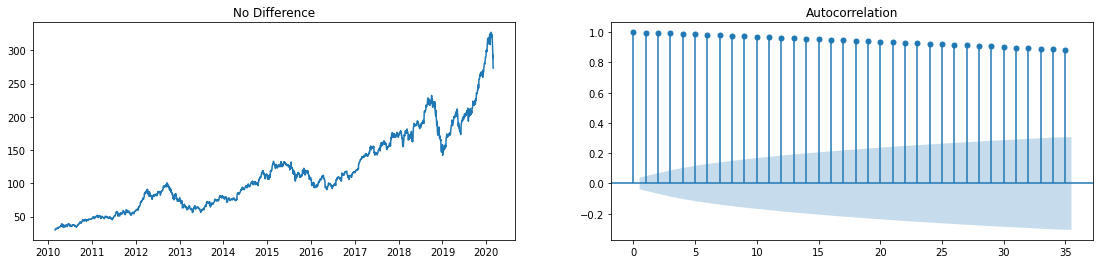

In [339]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 4))

ax1.plot(dataset)
ax1.set_title("No Difference")
#ax2.set_ylim(0, 1)
plot_acf(dataset, ax=ax2);

# PACF -- ACF PLOTS -- without differenciation

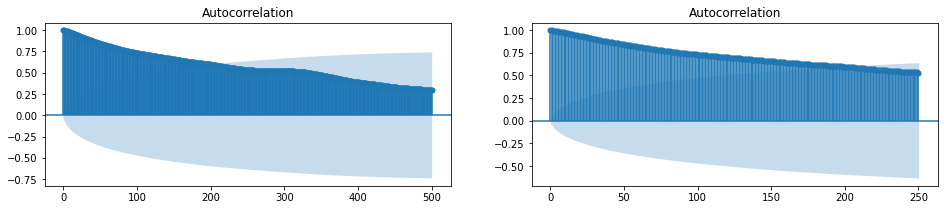

In [340]:
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(dataset['Close/Last'], lags=500, ax=axes[0]);
plot_acf(dataset['Close/Last'], lags=250, ax=axes[1]);

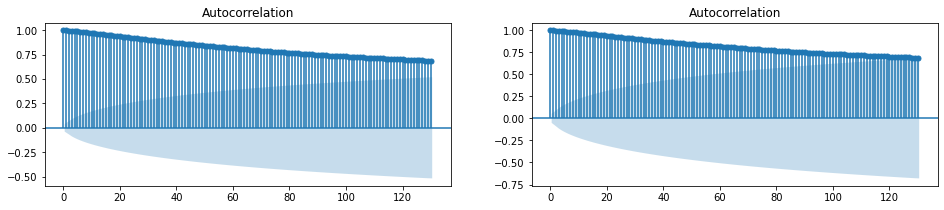

In [342]:
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(dataset['Close/Last'], lags=130, ax=axes[0]);
plot_acf(dataset['Close/Last'], lags=130, ax=axes[1], alpha= 0.01);

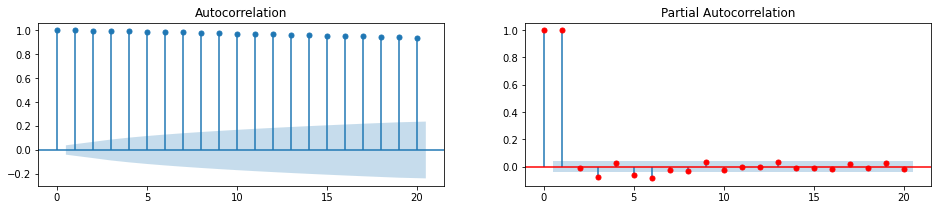

In [343]:
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(dataset['Close/Last'], lags=20, ax=axes[0]);#, alpha= 0.01);
plot_pacf(dataset['Close/Last'], lags=20, ax=axes[1], color='r');

# PACF PLOT -- differenciation once

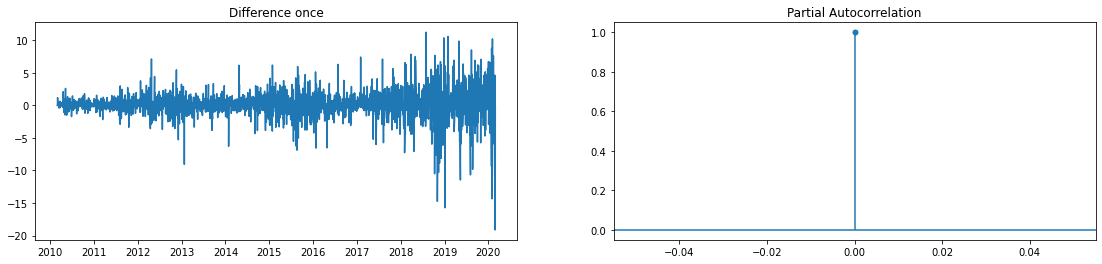

In [345]:

diff = dataset.diff() #df['Close/Last'].diff()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
#ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

# ACF PLOT -- differenciation once

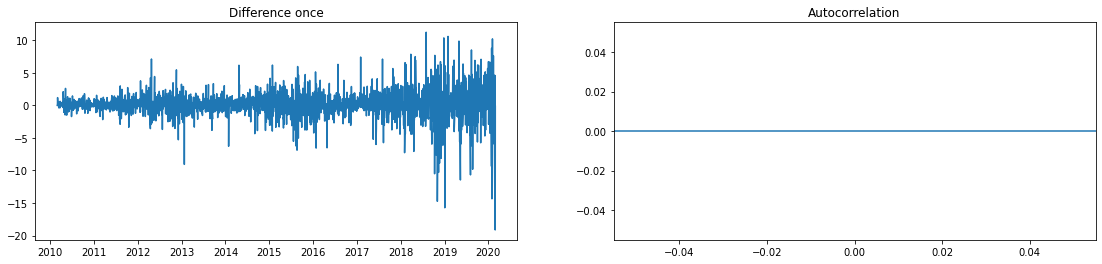

In [346]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
#ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

# PACF -- ACF PLOTS -- differenciation once

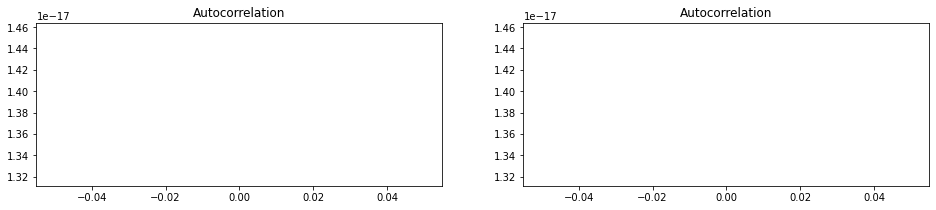

In [347]:
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(diff['Close/Last'], lags=10, ax=axes[0]);
plot_acf(diff['Close/Last'], lags=10, ax=axes[1]);


# ARIMA

In [348]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(dataset['Close/Last'])

1

In [349]:
arima = ARIMA(dataset['Close/Last'], order=(2,1,1)) # p,d,q
arima = arima.fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Close/Last   No. Observations:                 2517
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -5432.246
Method:                       css-mle   S.D. of innovations              2.094
Date:                Tue, 18 Jan 2022   AIC                          10874.493
Time:                        12:05:21   BIC                          10903.647
Sample:                             1   HQIC                         10885.074
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0971      0.040      2.399      0.016       0.018       0.176
ar.L1.D.Close/Last     0.1288      0.205      0.627      0.530      -0.274       0.531
ar.L2.D.Close/Last    -0.0454      0.020     -2.229      0.026      -0.085      -0.005
ma.L1.D.Close/Last    -0.1115      0.205     -0.544      0.586      -0.513       0.290
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4184           -4.4730j            4.6925           -0.2011
AR.2            1.4184           +4.4730j            4.6925            0.2011
MA.1            8.9694           +0.0000j            8.9694            0.0000
-----------------------------------------------------------------------------
"""

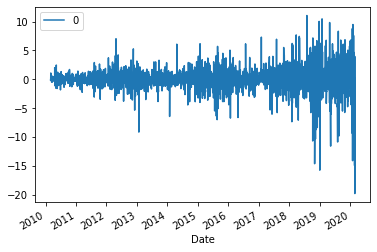

In [350]:
residuals=pd.DataFrame(arima.resid)
residuals.plot();

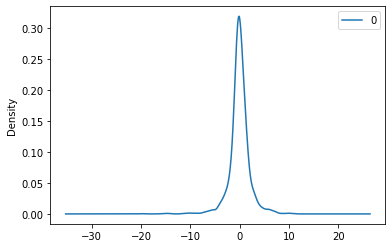

In [351]:
residuals.plot(kind='kde');

In [352]:
residuals.describe()

,0
count,2517.000000
mean,-0.000002
std,2.094850
min,-19.824749
25%,-0.755611
50%,-0.014891
75%,0.866913
max,11.040845


# Evaluate performance

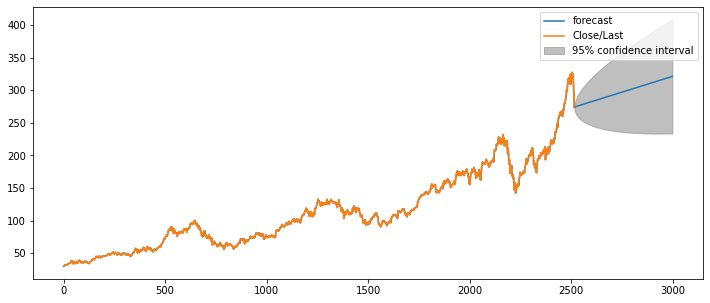

In [357]:
arima.plot_predict(end=3000);
fig = plt.gcf(); fig.set_size_inches(12, 5);

# Forecast

In [358]:
##splitting dataset into train and test split,  to predict the last 750 points

training_size=int(len(dataset)*0.7)
test_size=len(dataset)-training_size

df_train=dataset[0:training_size]
df_test = dataset[training_size:len(dataset)]

df_train.shape, df_test.shape

((1762, 1), (756, 1))

In [359]:
# Build Model
model_arima = ARIMA(df_train, order=(2,1,1))
model_arima = model_arima.fit(disp=0)

# Forecast
forecast, std_err, confidence_int = model_arima.forecast(len(df_test), alpha=0.05)  # 95% confidence

In [360]:
# We define here a "Plot forecast vs. real", which also shows historical train set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='green', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

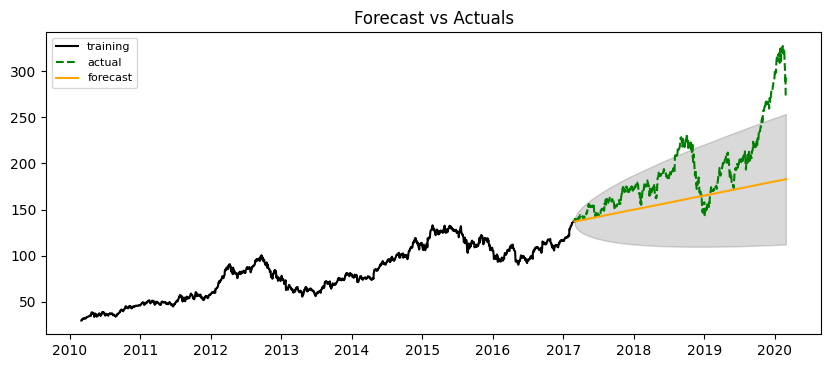

In [361]:
plot_forecast(forecast, df_train, df_test, confidence_int[:,0], confidence_int[:,1])

# Predict NEXT datapoint (1-day)

In [364]:
y_pred = df_test.shift(1)
y_pred

,Close/Last
Date,
2017-02-28,NaN
2017-03-01,136.99
2017-03-02,139.79
2017-03-03,138.96
2017-03-06,139.78
...,...
2020-02-24,313.05
2020-02-25,298.18
2020-02-26,288.08


In [365]:
from sklearn.metrics import r2_score

y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]
print(f"R2:{r2_score(y_true, y_pred)}")

R2:0.9942490037845106


In [366]:
#Linear model with 12 auto-regressive features
#Let's build our dataset X with 12 auto-regressive features

df2 = dataset.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['Close/Last'].shift(i)
    df2_test[f't - {i}'] = df_test['Close/Last'].shift(i)

df2_train.dropna(inplace=True)    
df2_test.dropna(inplace=True)    
df2_train.head()

,Close/Last,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
Date,,,,,,,,,,,,,
2010-03-17,32.0171,32.0643,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014,29.9043,29.8357,29.8557
2010-03-18,32.0928,32.0171,32.0643,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014,29.9043,29.8357
2010-03-19,31.7500,32.0928,32.0171,32.0643,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014,29.9043
2010-03-22,32.1071,31.7500,32.0928,32.0171,32.0643,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786,30.1014
2010-03-23,32.6228,32.1071,31.7500,32.0928,32.0171,32.0643,31.9771,32.3714,32.2143,32.1200,31.8600,31.2971,31.2786


In [367]:
# Train Test Split
X2_train = df2_train.drop(columns = ['Close/Last'])
y2_train = df2_train['Close/Last']
X2_test = df2_test.drop(columns = ['Close/Last'])
y2_test = df2_test['Close/Last']

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(1750, 12) (1750,) (744, 12) (744,)


R2:  0.9941155369695243


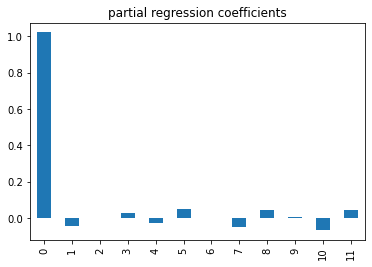

In [368]:
# Predict and measure R2
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');